# Modeling a Helical-Cruciform Fuel Rod Assembly

This notebook is intended to demonstrate how to use ROBIN3's [Python API](../pythonapi/index.rst) to simulate a helical-cruciform fuel rod assembly. 

In [27]:
%matplotlib inline
import math
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import robin3
plt.rcParams['figure.figsize'] = [12, 6]
robin3.config.USE_TQDM_NOTEBOOK = True

## Defining Materials

Here we define a [material] (../io_formats/input.rst#material-object) list containing a 4.5% enriched UO2 material as follows:

In [28]:
uo2 = {
    "name": "FUEL",
    "elements": ["UO2_4.5"],
    "weight_percents": [1.0],
    "density": 10.0
}
materials = [uo2]

## Defining Pin Structures

First we create a guide tube [structure](../io_formats/input.rst#structure-object).

In [29]:
guide_tube = {
    "name": "GT",
    "primitives": [
        {"type": "CIRCLE", "radius": 0.5615},
        {"type": "CIRCLE", "radius": 0.6120},
    ],
    "regions": [
        {"material": "ZIRC4", "space": "2-1"},
    ]
}

Note here we do not define the region inside the guide tube, ROBIN3 will automactically "fill" the undefined regions with moderator. Material "ZIR4" are pre-defined in ROBIN3's [material databank file](../io_formats/materialdb.rst), which can be inspected by [robin3.get_predefined_materials](../pythonapi/generated/robin3.get_predefined_materials.rst) as well.

Second we define some functions in order to generate helical-cruciform fuel rod [structure](../io_formats/input.rst#structure-object) at different twist angle conveniently.

In [30]:
def rotate(angle, point):
    PI = 3.1425926
    angle = angle / 180 * PI
    x, y = point
    _x = math.cos(angle) * x - math.sin(angle) * y
    _y = math.sin(angle) * x + math.cos(angle) * y
    return _x, _y

def circle(radius, center):
    x, y = center
    return {"type": "CIRCLE", 
            "radius": radius,
            "center": {"x": x, "y": y}}

def helical_cruciform_rod(name, rotate_angle, scale, num_rings):
    r1, r2, r3, r4, r5 = np.array(
        [0.1046, 0.1147, 0.1859, 0.3475, 0.5334]) * scale
    centers_in = [rotate(rotate_angle, p) for p in [(-1, 0), (0, -1), (1, 0), (0, 1)]]
    centers_in = np.array(centers_in) * r5
    centers_out = [rotate(rotate_angle, p) for p in [(-1, -1), (1, -1), (1, 1), (-1, 1)]]
    centers_out = np.array(centers_out) * r5
    primitives = [{"type": "POLYGON",
           "vertexes": [{"x": x, "y": y} for x, y in centers_out]}]
    regions, start, container_inner = [], 2, ''
    for radius, material in zip([r1, r2, r3], ["FUEL", "HE", "ZIRC4"]):
        for p in centers_in:
            primitives.append(circle(radius, p))
        for p in centers_out:
            primitives.append(circle(r4+r3-radius, p))
        container = "{}|{}|{}|{}|(1-{}-{}-{}-{})".format(*np.arange(start, start+8))
        space = container if not container_inner else "({})-({})".format(container, container_inner)
        regions.append({"material": material, "space": space})
#         break
        container_inner = container
        start += 8
    meshing = {
        "type": "SECTORS",
        "num_azimuths": 8,
        "radii": [0.2, 0.35, r5+r3]
    }
    return {"name": name, "meshing": meshing, "primitives": primitives, "regions": regions}

We use function defined above to create helical-cruciform fuel rod [structure](../io_formats/input.rst#structure-object) at a squence of twist angles: [0, 15, 30, 45, 60, 75].

In [31]:
rotate_angles = np.linspace(0, 90, 7)[:-1]
names = ["HC{}".format(int(a)) for a in rotate_angles]
structures = [helical_cruciform_rod(n, a, 1.24/1.44, 6) for n, a in zip(names, rotate_angles)]
structures.append(guide_tube)
pprint(structures)

[{'meshing': {'num_azimuths': 8,
              'radii': [0.2, 0.35, 0.6193972222222223],
              'type': 'SECTORS'},
  'name': 'HC0',
  'primitives': [{'type': 'POLYGON',
                  'vertexes': [{'x': -0.4593166666666667,
                                'y': -0.4593166666666667},
                               {'x': 0.4593166666666667,
                                'y': -0.4593166666666667},
                               {'x': 0.4593166666666667,
                                'y': 0.4593166666666667},
                               {'x': -0.4593166666666667,
                                'y': 0.4593166666666667}]},
                 {'center': {'x': -0.4593166666666667, 'y': 0.0},
                  'radius': 0.09007222222222222,
                  'type': 'CIRCLE'},
                 {'center': {'x': 0.0, 'y': -0.4593166666666667},
                  'radius': 0.09007222222222222,
                  'type': 'CIRCLE'},
                 {'center': {'x': 0.4593166666666667,

## Defining Assemblies

Here we define a list of 17x17 square [Assembly](../io_formats/input.rst#assembly-object) at different twist angles. That means we treat different twist angle assemblies as different kind of assemblies.

In [32]:
def assembly(name, angle):
    rod = "HC{}".format(int(angle))
    return {
        "name": "hc_assembly_{}_degrees_twisted".format(int(angle)),
        "type": "SQUARE",
        "symmetry": 8,
        "pitch": 21.504,
        "cell_pitch": 1.26,
        "cell_map": [
            rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod,
            rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod,
            rod, rod, rod, rod, rod,"GT", rod, rod,"GT", rod, rod,"GT", rod, rod, rod, rod, rod,
            rod, rod, rod,"GT", rod, rod, rod, rod, rod, rod, rod, rod, rod,"GT", rod, rod, rod,
            rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod,
            rod, rod,"GT", rod, rod,"GT", rod, rod,"GT", rod, rod,"GT", rod, rod,"GT", rod, rod,
            rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod,
            rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod,
            rod, rod,"GT", rod, rod,"GT", rod, rod,"GT", rod, rod,"GT", rod, rod,"GT", rod, rod,
            rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod,
            rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod,
            rod, rod,"GT", rod, rod,"GT", rod, rod,"GT", rod, rod,"GT", rod, rod,"GT", rod, rod,
            rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod,
            rod, rod, rod,"GT", rod, rod, rod, rod, rod, rod, rod, rod, rod,"GT", rod, rod, rod,
            rod, rod, rod, rod, rod,"GT", rod, rod,"GT", rod, rod,"GT", rod, rod, rod, rod, rod,
            rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod,
            rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod, rod
        ]
    }
assembly_names = ["hc_assembly_{}_degrees_twisted".format(int(angle)) for angle in rotate_angles]
assemblies = [assembly(n, a) for n, a in zip(assembly_names, rotate_angles)]

## Defining State Points

[State points](../io_formats/input.rst#state-points-object) is required for micro xs cases, here we provides [burnup points](../io_formats/input.rst#burnup-points) and [power density](../io_formats/input.rst#power-density) to perform single assembly depletion calculation:

In [33]:
state_points = {
    "boron_concentration": 500,
    "moderator_temperature": 577,
    "fuel_temperature": 903,
    "system_pressure": 15.51
}

## Composing Input Model

The full [input model](../io_formats/input.rst) for a typical single assembly depletion calculation includes following parts:
    1. [materials](../io_formats/input.rst#materials-array);
    2. [structures](../io_formats/input.rst#structures-array);
    3. [assemblies](../io_formats/input.rst#assemblies-array);
    4. [state points](../io_formats/input.rst#state-points-object).

Here we define a list of models, each model represent a certain twisted assembly:

In [34]:
models = [{
    "materials": materials,
    "structures": structures,
    "assemblies": [assembly],
    "state_points": state_points
} for assembly in assemblies]
# import json
# with open('hc_assembly.json', 'w') as f:
#     json.dump(model[0], f)

## Visualizing Input Model

Instantiates a list of [robin3.plotter](../pythonapi/generated/robin3.Plotter.rst) to visualize assemblies at different twist angles with fine meshes.

In [35]:
plotters = [robin3.Plotter(model) for model in models]

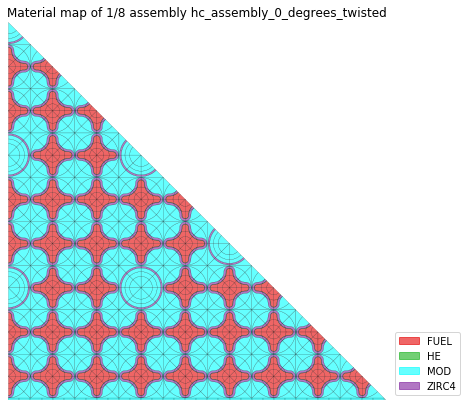

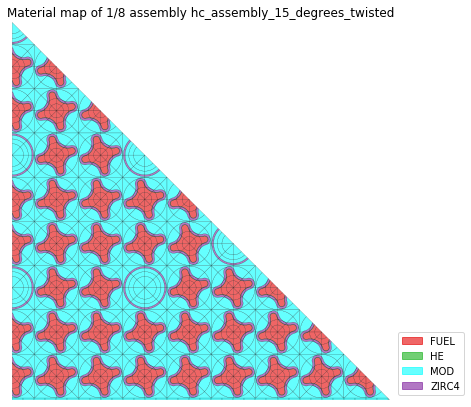

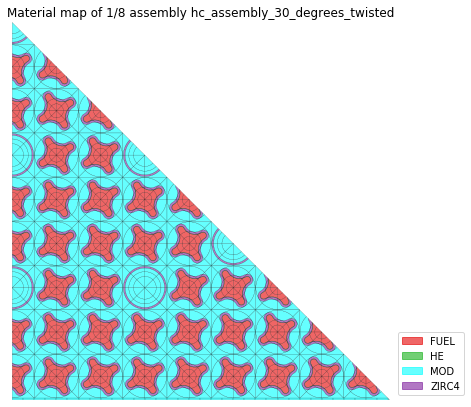

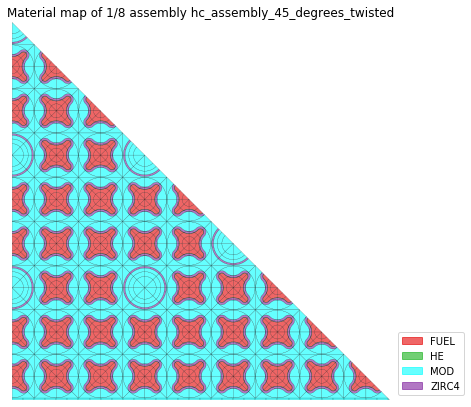

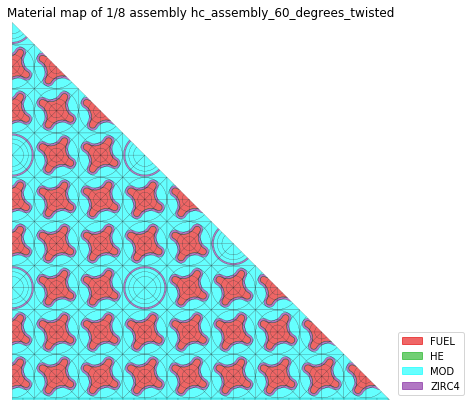

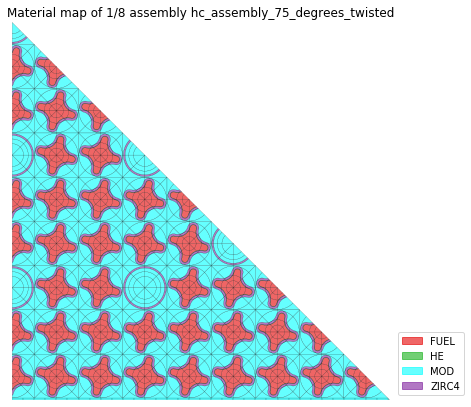

In [36]:
for plotter in plotters:
    fig = plotter.plot_geometry(show_meshes=True)

Display flat source regions for the 0 degree twisted assembly:

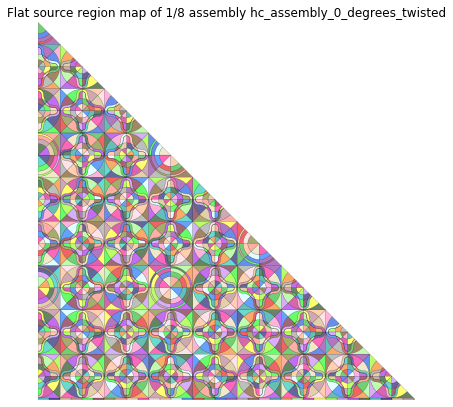

In [37]:
fig = plotters[0].plot_flat_source_regions()

## Run ROBIN3

Running ROBIN3 from Python can be done using the [robin3.run()](../pythonapi/generated/robin3.run.rst) function. This function allows you to use GPU by setting use_GPU=True if it needed, GPU will significantly reduce the running time.

In [38]:
results = [robin3.run(model, use_gpu=True) for model in models]

In [39]:
print(results)

[<robin3.result_process.ResultProcessor object at 0x7fab64472668>, <robin3.result_process.ResultProcessor object at 0x7fab646b32b0>, <robin3.result_process.ResultProcessor object at 0x7fab942512e8>, <robin3.result_process.ResultProcessor object at 0x7fab843d6cf8>, <robin3.result_process.ResultProcessor object at 0x7fab336e7048>, <robin3.result_process.ResultProcessor object at 0x7fab843d6828>]


The [robin3.run()](../pythonapi/generated/robin3.run.rst) function return a [robin3.ResultProcessor](../pythonapi/generated/robin3.ResultProcessor.rst) instance. Here we get a list of [robin3.ResultProcessor](../pythonapi/generated/robin3.ResultProcessor.rst) instance for each twisted assembly. All the result data can be accessed by the result_data attribute, and the result data are saved by a HDF5 file named by
result_file attribute, summary result data such as keff can be inspected by method summary which return a pandas DataFrame.

In [40]:
print(result.result_file for result in results)
for result in results: 
    df = result.summary()
    print(df)

<generator object <genexpr> at 0x7fabafa382a0>
   burnup    tmo    tfu    bor      keff      kinf  keff_apply_buckling  \
0     0.0  577.0  903.0  500.0  1.338817  1.339171             1.339033   

   buckling  peak_pin_power  std_pin_power  
0       0.0        1.058613       0.455553  
   burnup    tmo    tfu    bor      keff      kinf  keff_apply_buckling  \
0     0.0  577.0  903.0  500.0  1.345454  1.345726             1.345588   

   buckling  peak_pin_power  std_pin_power  
0       0.0        1.056977       0.455645  
   burnup    tmo    tfu    bor      keff      kinf  keff_apply_buckling  \
0     0.0  577.0  903.0  500.0  1.346748  1.347081             1.346943   

   buckling  peak_pin_power  std_pin_power  
0       0.0        1.056411       0.455605  
   burnup    tmo    tfu    bor      keff      kinf  keff_apply_buckling  \
0     0.0  577.0  903.0  500.0  1.342109  1.342314             1.342176   

   buckling  peak_pin_power  std_pin_power  
0       0.0        1.058085       

## Result Visualization

Result visualization from Python can be done using a [robin3.Plotter](../pythonapi/generated/robin3.Plotter.rst) instance generate by [ResultProcessor](../pythonapi/generated/robin3.ResultProcessor.rst)'s method generate_plotter.

In [41]:
plotters = [result.generate_plotter() for result in results]

Display depletion and resonance regions for the 0 degree twisted assembly:

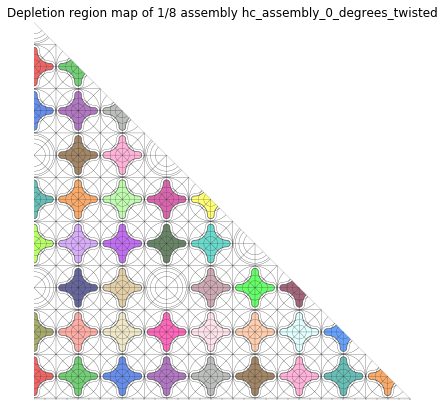

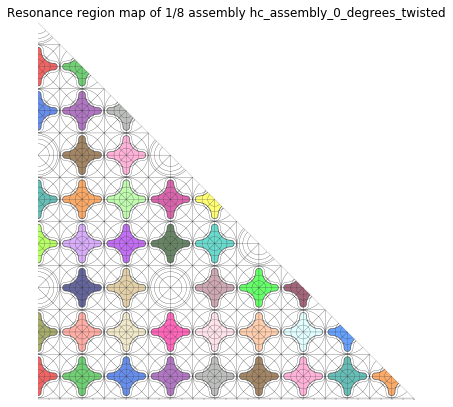

In [42]:
fig = plotters[0].plot_depletion_regions()
fig = plotters[0].plot_resonance_regions()

By the figures above we can see depletion regions are the same as the resonance regions in this case. 

Display pin power for each assembly:

hc_assembly_0_degrees_twisted:


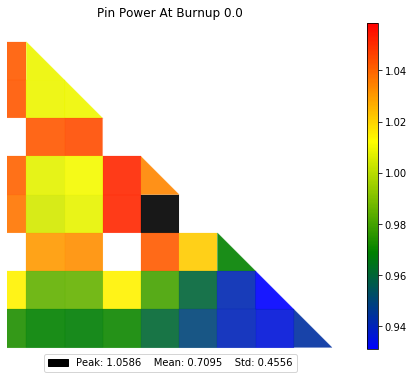

hc_assembly_15_degrees_twisted:


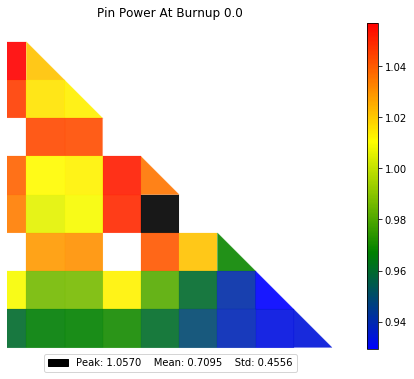

hc_assembly_30_degrees_twisted:


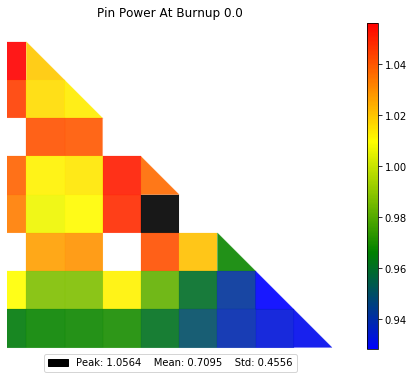

hc_assembly_45_degrees_twisted:


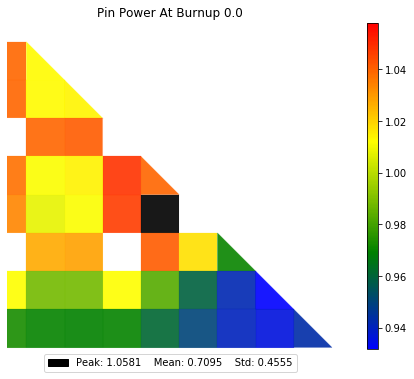

hc_assembly_60_degrees_twisted:


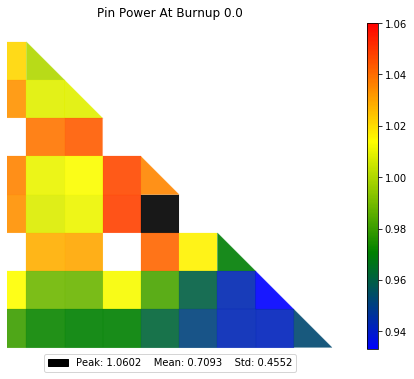

hc_assembly_75_degrees_twisted:


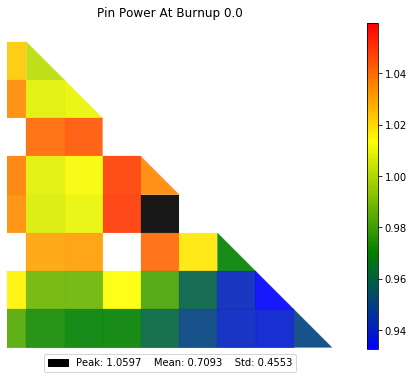

In [46]:
for plotter, assembly in zip(plotters, assembly_names):
    print(assembly +':')
    fig = plotter.plot_pin_power()

Display mesh flux distribution of energy group 1 (fast group) and 2 (thermal group) for each assembly:

hc_assembly_0_degrees_twisted:


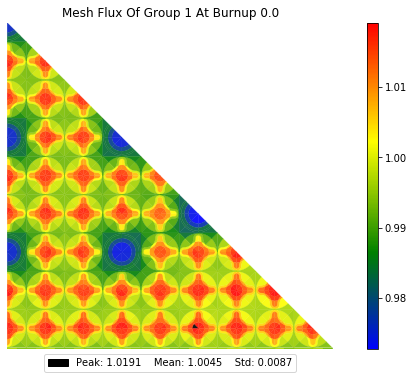

hc_assembly_15_degrees_twisted:


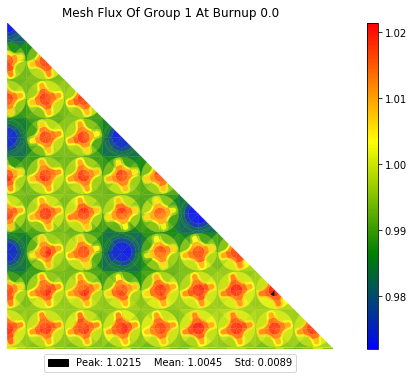

hc_assembly_30_degrees_twisted:


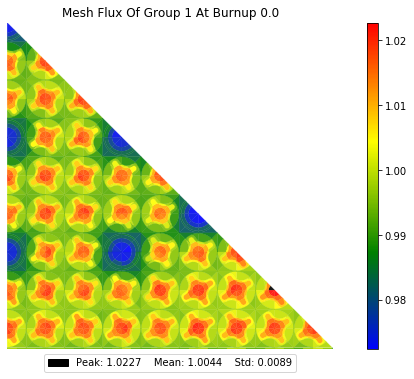

hc_assembly_45_degrees_twisted:


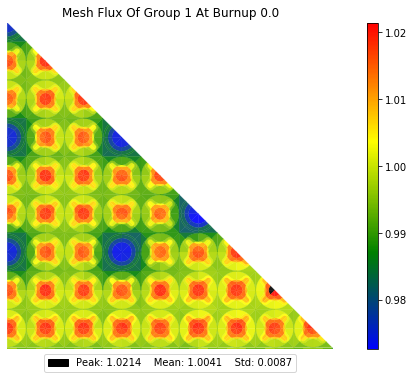

hc_assembly_60_degrees_twisted:


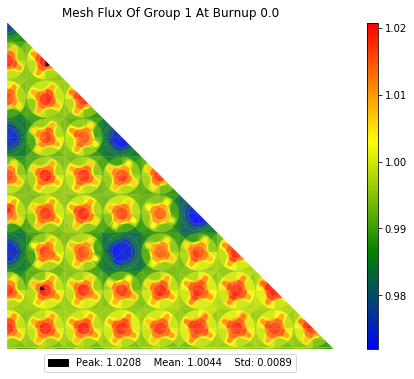

hc_assembly_75_degrees_twisted:


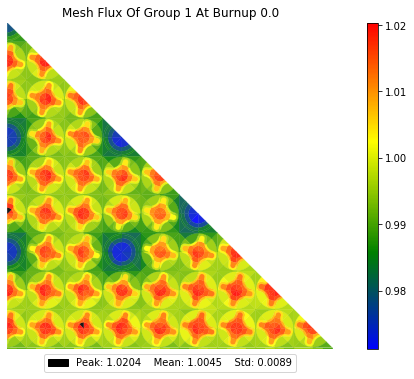

hc_assembly_0_degrees_twisted:


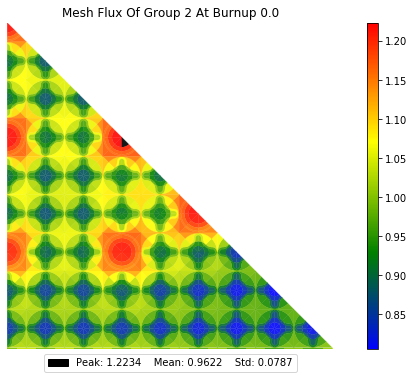

hc_assembly_15_degrees_twisted:


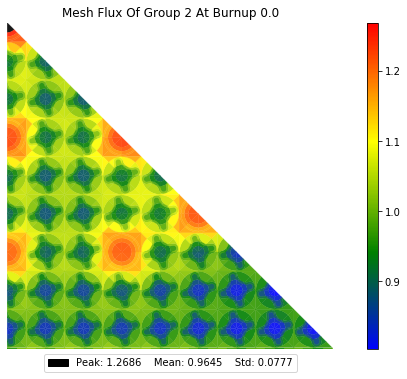

hc_assembly_30_degrees_twisted:


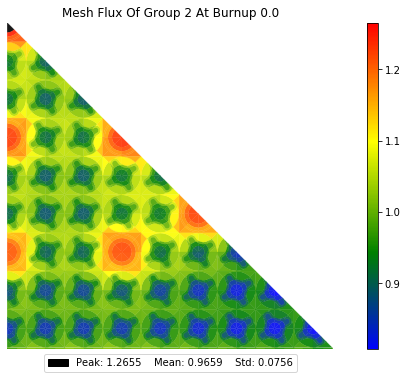

hc_assembly_45_degrees_twisted:


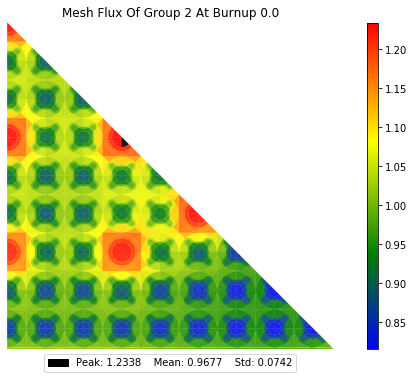

hc_assembly_60_degrees_twisted:


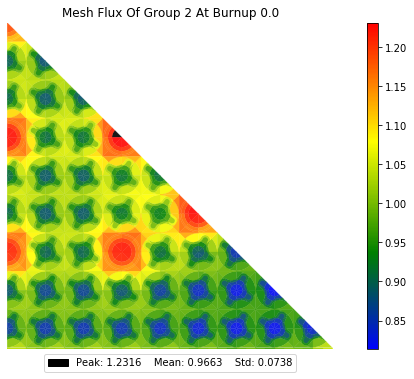

hc_assembly_75_degrees_twisted:


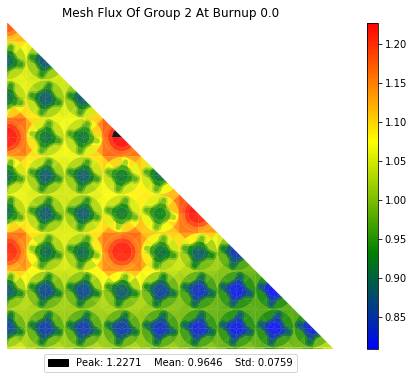

In [47]:
for g in [1, 2]:
    for plotter, assembly in zip(plotters, assembly_names):
        print(assembly + ':')
        fig = plotter.plot_mesh_flux(group=g)